In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [46]:
df = pd.read_csv("../Data/glassdoor_jobs.csv", index_col=0)
print(df.shape)
df.sample(3)

(7984, 12)


,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,Sector,Revenue
63,iOS Developer - Garmin Jr.,$52K - $96K,Are you interested in working with a small tea...,4.1,Garmin,"Olathe, KS",10000+ Employees,1989,1989,Consumer Products Manufacturing,Manufacturing,$2 to $5 billion (USD)
161,Web Software Developer,$60K - $114K,"Renkim Corporation, a Print & Electronic commu...",3.4,Renkim Corporation,"Southgate, MI",51 to 200 Employees,1982,1982,Business Service Centers & Copy Shops,Business Services,$25 to $50 million (USD)
312,Division of Intuit,-1,Overview\nOur focus is all about building stuf...,4.3,Intuit - Software Engineering,"Staff Software Engineer, Android",5001 to 10000 Employees,1983,1983,Computer Hardware & Software,Information Technology,$2 to $5 billion (USD)


In [47]:
def title_simplifier(title):
    if 'data scientist' in title.lower() or 'data engineer' in title.lower():
        return 'data scientist/engineer'
    elif 'android' in title.lower() or 'ios' in title.lower():
        return 'mobile app dev'
    elif 'analyst' in title.lower() or 'analytic' in title.lower():
        return 'analyst'
    elif 'machine learning' in title.lower():
        return 'mle'
    elif 'python' in title.lower():
        return 'python developer/engineer'
    elif 'research' in title.lower():
        return 'research engineer/scientist'
    elif 'devops' in title.lower():
        return 'devops'
    elif 'software' in title.lower() or '.net' in title.lower():
        return 'software developer/engineer'
    else:
        return 'other'
    
def seniority(title):
    if 'sr' in title.lower() or 'senior' in title.lower() or 'director' in title.lower() or 'vp' in title.lower() or 'lead' in title.lower() or 'principal' in title.lower():
            return 'senior'
    elif 'jr' in title.lower() or 'junior' in title.lower() or 'associate' in title.lower() or 'graduate' in title.lower():
        return 'jr'
    else:
        return 'mid/other'


def get_max_salary(s):
    try:        
        return (int(s.split('-')[1]))
    except:
        return (int(s.split('-')[0]))

def get_location(s):
    try: 
        if(s.lower()=='Remote'):
            return 'Remote'
        elif(('los angeles' in s.lower()) or ('california' in s.lower())):
            return 'CA'
        elif('michigan' in s.lower()):
            return 'MI'
        elif('michigan' in s.lower()):
            return 'MI'
        else:
            return ((s.split(','))[1]).strip()        
    except:
        return s.strip()
    
def company_age(y):
    age=-1
    try:     
        if(y!='-1'):
            age = 2021 - int(y)
    except:
        age=-1
        
    return age


# drop duplicates
df = df.drop_duplicates()
print(df.shape)


# dropping all the rows where target column value (Salary Estimate) is missing
df = df[df['Salary Estimate']!='-1']
df = df.reset_index(drop=True)
print(df.shape)

# is salary per-hour or not?
df['hourly'] = df['Salary Estimate'].apply(lambda x: 1 if 'per hour' in x.lower() else 0)
df['employer_provided'] = df['Salary Estimate'].apply(lambda x: 1 if 'employer provided' in x.lower() else 0)

# parse salary range
salary = df['Salary Estimate'].apply(lambda x: (x.split('(')[0]).replace('$','').replace('K', ''))
salary_range = salary.apply(lambda x: x.lower().replace('per hour', '').replace('employer provided salary:', ''))

# get min, max, and average salary from salary range
df['min_salary'] = salary_range.apply(lambda x: int((x.split('-'))[0]))
df['max_salary'] = salary_range.apply(lambda x: get_max_salary(x))
df['avg_salary'] = (df['min_salary']+df['max_salary'])/2

# get job state
df['job_state'] = df['Location'].apply(lambda x: get_location(x))

# get company age
df['age'] = df.Founded.apply(lambda x: company_age(x))

# # fill-in missing ratings with np.nans 
# df.Rating = df.Rating.apply(lambda x: np.nan if x<1 else x)

# Handling -1s in revenue
df['Revenue'] = df.Revenue.apply(lambda x: x if x !='-1' else 'Unknown / Non-Applicable')

# simplified job title
df['job_title_tag'] = df['Job Title'].apply(title_simplifier)

# determine seniority level
df['seniority'] = df['Job Title'].apply(seniority)
print(df['seniority'].value_counts())
print(df['job_title_tag'].value_counts())

# converting hourly wage to annual salary
df['min_salary'] = df.apply(lambda x: x.min_salary*2 if x.hourly ==1 else x.min_salary, axis =1)
df['max_salary'] = df.apply(lambda x: x.max_salary*2 if x.hourly ==1 else x.max_salary, axis =1)

#  Job description length 
df['desc_len'] = df['Job Description'].apply(lambda x: len(x))

print(df['Type of ownership'].value_counts())

# replacing all numeric values with 'Unknown'
df['Type of ownership'] = df['Type of ownership'].str.strip().replace('[-\s+]', '', regex=True).replace('\d+', 'Unknown', regex=True)

# replacing -1s in Size column from 'Unknown'
df.Size = df.Size.replace('-1', 'Unknown')
print(df.Size.value_counts())

print(df['Type of ownership'].value_counts())

(6507, 12)
(4917, 12)
mid/other    3750
senior       1074
jr             93
Name: seniority, dtype: int64
other                          2245
analyst                        1047
software developer/engineer     818
mobile app dev                  550
data scientist/engineer         168
research engineer/scientist      39
devops                           23
python developer/engineer        16
mle                              11
Name: job_title_tag, dtype: int64
-1                                959
Company - Private                 560
Company - Public                  140
1969                              110
1999                              103
1994                               83
1980                               80
1996                               67
2000                               64
1997                               64
1998                               62
Nonprofit Organization             57
2015                               55
2007                               52
2008

In [48]:
# python
df['python'] = df['Job Description'].apply(lambda x: 1 if 'python' in x.lower() else 0)
print(df.python.value_counts())

# r studio 
df['R'] = df['Job Description'].apply(lambda x: 1 if 'r studio' in x.lower() or 'r-studio' in x.lower() else 0)
print(df.R.value_counts())

# spark 
df['spark'] = df['Job Description'].apply(lambda x: 1 if 'spark' in x.lower() else 0)
print(df.spark.value_counts())

# aws 
df['aws'] = df['Job Description'].apply(lambda x: 1 if 'aws' in x.lower() else 0)
print(df.aws.value_counts())

# excel
df['excel'] = df['Job Description'].apply(lambda x: 1 if 'excel' in x.lower() else 0)
print(df.excel.value_counts())

# sql
df['sql'] = df['Job Description'].apply(lambda x: 1 if 'sql' in x.lower() else 0)
print(df.sql.value_counts())

# django
df['django'] = df['Job Description'].apply(lambda x: 1 if 'django' in x.lower() else 0)
print(df.django.value_counts())

# hadoop
df['hadoop'] = df['Job Description'].apply(lambda x: 1 if 'hadoop' in x.lower() else 0)
print(df.hadoop.value_counts())

# java
df['java'] = df['Job Description'].apply(lambda x: 1 if 'java' in x.lower() else 0)
print(df.java.value_counts())

# db
df['db'] = df['Job Description'].apply(lambda x: 1 if 'database' in x.lower() else 0)
print(df.db.value_counts())

# tableau
df['tableau'] = df['Job Description'].apply(lambda x: 1 if 'tableau' in x.lower() else 0)
print(df.tableau.value_counts())

# azure
df['azure'] = df['Job Description'].apply(lambda x: 1 if 'azure' in x.lower() else 0)
print(df.azure.value_counts())

0    4812
1     105
Name: python, dtype: int64
0    4913
1       4
Name: R, dtype: int64
0    4888
1      29
Name: spark, dtype: int64
0    4734
1     183
Name: aws, dtype: int64
0    4358
1     559
Name: excel, dtype: int64
0    4570
1     347
Name: sql, dtype: int64
0    4913
1       4
Name: django, dtype: int64
0    4903
1      14
Name: hadoop, dtype: int64
0    4550
1     367
Name: java, dtype: int64
0    4458
1     459
Name: db, dtype: int64
0    4884
1      33
Name: tableau, dtype: int64
0    4867
1      50
Name: azure, dtype: int64


In [26]:
df.describe()

,Rating,hourly,employer_provided,min_salary,max_salary,avg_salary,age,desc_len,python,R,spark,aws,excel,sql,django,hadoop,java,db,tableau,azure
count,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000
mean,2.658288,0.006711,0.006711,59.957291,113.205817,86.359467,29.468782,1023.683547,0.021354,0.000814,0.005898,0.037218,0.113687,0.070571,0.000814,0.002847,0.074639,0.093350,0.006711,0.010169
std,2.070068,0.081656,0.081656,20.257923,36.637693,27.861721,42.887350,840.005442,0.144578,0.028513,0.076579,0.189314,0.317463,0.256134,0.028513,0.053289,0.262835,0.290951,0.081656,0.100337
min,-1.000000,0.000000,0.000000,16.000000,21.000000,9.500000,-1.000000,44.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.500000,0.000000,0.000000,47.000000,91.000000,69.000000,-1.000000,653.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.600000,0.000000,0.000000,58.000000,112.000000,85.500000,15.000000,815.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,0.000000,0.000000,71.000000,134.000000,102.000000,42.000000,1062.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,1.000000,1.000000,227.000000,581.000000,404.000000,281.000000,9315.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
df.corr()

,Rating,hourly,employer_provided,min_salary,max_salary,avg_salary,age,desc_len,python,R,spark,aws,excel,sql,django,hadoop,java,db,tableau,azure
Rating,1.000000,-0.041426,-0.055867,0.130966,0.094291,0.114705,0.360537,0.159497,0.005628,0.013671,0.026061,0.040297,0.030711,0.007433,0.004711,0.018595,0.014360,-0.019337,0.022115,0.008115
hourly,-0.041426,1.000000,0.511876,-0.017781,-0.081715,-0.157172,-0.017976,0.021849,-0.012142,-0.002345,-0.006331,-0.003003,0.001949,-0.012924,-0.002345,-0.004392,-0.023345,-0.017814,-0.006757,-0.008332
employer_provided,-0.055867,0.511876,1.000000,0.054773,-0.044522,-0.074020,-0.043185,-0.035732,-0.012142,-0.002345,-0.006331,0.010156,-0.005898,-0.012924,-0.002345,-0.004392,-0.023345,-0.009252,-0.006757,-0.008332
min_salary,0.130966,-0.017781,0.054773,1.000000,0.882046,0.939452,0.079445,0.117797,0.072682,-0.010153,0.049465,0.057274,-0.005729,0.041745,0.012386,0.029320,0.117427,0.018485,-0.023437,0.040044
max_salary,0.094291,-0.081715,-0.044522,0.882046,1.000000,0.981955,0.039296,0.108608,0.066029,-0.007170,0.047636,0.047609,-0.015689,0.049110,0.019117,0.031373,0.111608,0.027871,-0.028951,0.049841
avg_salary,0.114705,-0.157172,-0.074020,0.939452,0.981955,1.000000,0.057348,0.114630,0.071014,-0.008178,0.049917,0.050645,-0.012406,0.048437,0.017300,0.031713,0.118335,0.026097,-0.026900,0.048136
age,0.360537,-0.017976,-0.043185,0.079445,0.039296,0.057348,1.000000,0.113491,-0.009456,-0.004970,0.025048,0.025861,0.010428,-0.010234,-0.016115,-0.012333,0.003175,-0.010501,-0.005604,0.001019
desc_len,0.159497,0.021849,-0.035732,0.117797,0.108608,0.114630,0.113491,1.000000,0.162554,-0.003293,0.102496,0.290707,0.282777,0.174346,0.020360,0.058660,0.117960,0.189170,0.135302,0.106082
python,0.005628,-0.012142,-0.012142,0.072682,0.066029,0.071014,-0.009456,0.162554,1.000000,-0.004215,0.227470,0.089868,0.080053,0.200994,0.193163,0.071315,0.198936,0.078331,0.125702,0.055141
R,0.013671,-0.002345,-0.002345,-0.010153,-0.007170,-0.008178,-0.004970,-0.003293,-0.004215,1.000000,-0.002198,-0.005610,-0.010219,0.019991,-0.000814,-0.001525,-0.008104,-0.009156,0.085022,-0.002892


<AxesSubplot:>

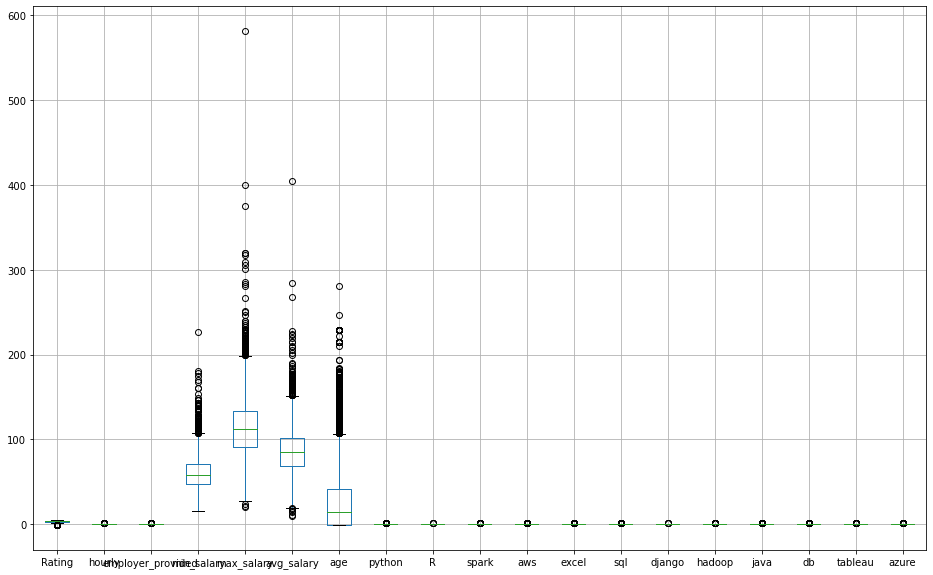

In [28]:
df.loc[:, df.columns != 'desc_len'].boxplot(figsize=(16,10))

<AxesSubplot:>

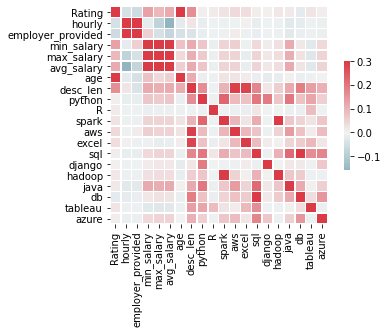

In [29]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df.corr(),vmax=.3, center=0, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<AxesSubplot:>

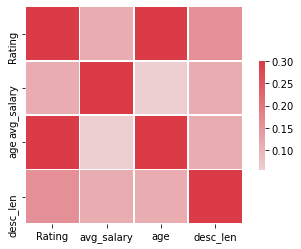

In [30]:
cor = df[['Rating', 'avg_salary', 'age', 'desc_len']].corr()

sns.heatmap(cor,vmax=.3, center=0, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

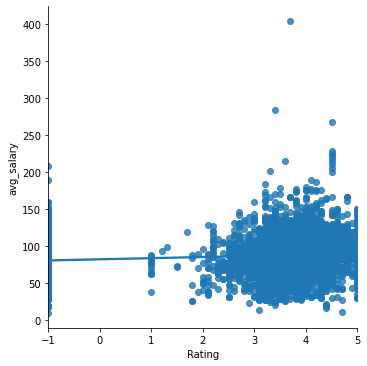

In [31]:
sns.lmplot(x='Rating',y='avg_salary', data=df, fit_reg=True)

[[<AxesSubplot:title={'center':'Rating'}>
  <AxesSubplot:title={'center':'hourly'}>
  <AxesSubplot:title={'center':'employer_provided'}>
  <AxesSubplot:title={'center':'min_salary'}>]
 [<AxesSubplot:title={'center':'max_salary'}>
  <AxesSubplot:title={'center':'avg_salary'}>
  <AxesSubplot:title={'center':'age'}>
  <AxesSubplot:title={'center':'desc_len'}>]
 [<AxesSubplot:title={'center':'python'}>
  <AxesSubplot:title={'center':'R'}>
  <AxesSubplot:title={'center':'spark'}>
  <AxesSubplot:title={'center':'aws'}>]
 [<AxesSubplot:title={'center':'excel'}>
  <AxesSubplot:title={'center':'sql'}>
  <AxesSubplot:title={'center':'django'}>
  <AxesSubplot:title={'center':'hadoop'}>]
 [<AxesSubplot:title={'center':'java'}>
  <AxesSubplot:title={'center':'db'}>
  <AxesSubplot:title={'center':'tableau'}>
  <AxesSubplot:title={'center':'azure'}>]]


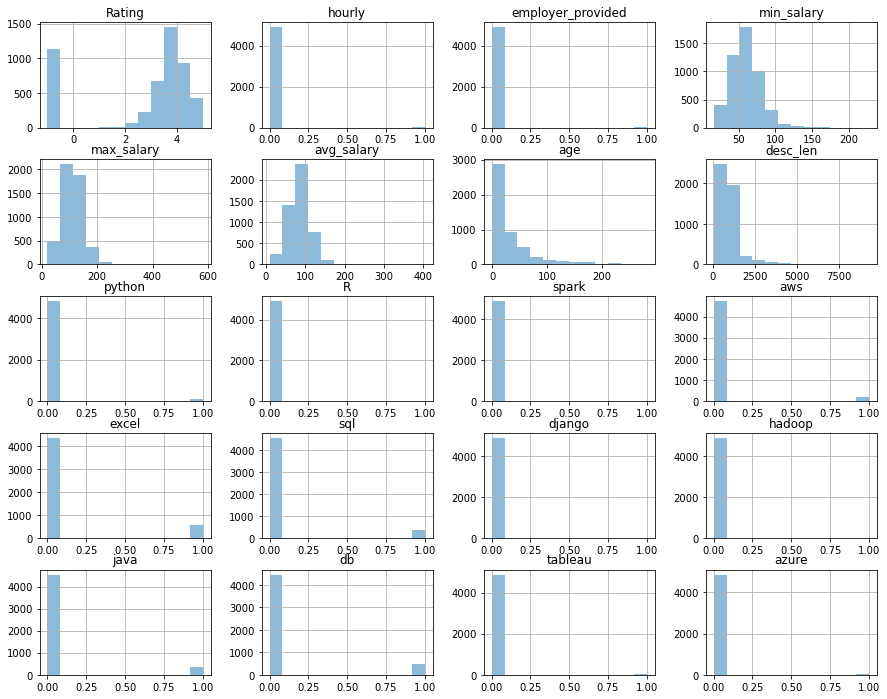

In [32]:
print(df.hist(bins=12, alpha=0.5, figsize=(15,12)))

graph for Size: total = 8


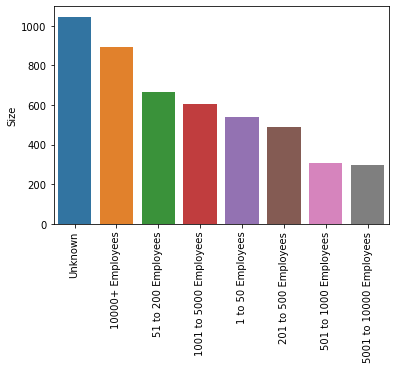

graph for Type of ownership: total = 12


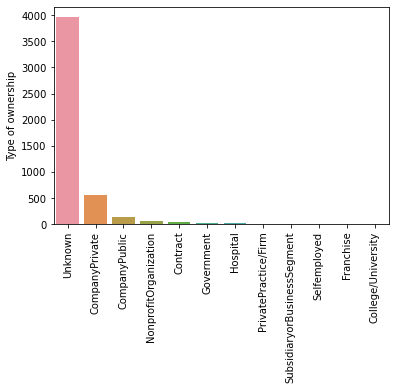

graph for Company Name: total = 3204


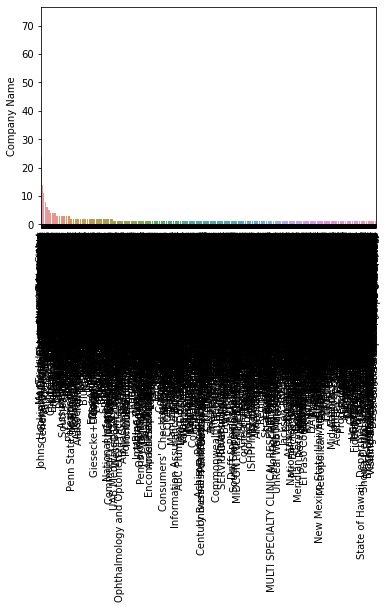

graph for Industry: total = 138


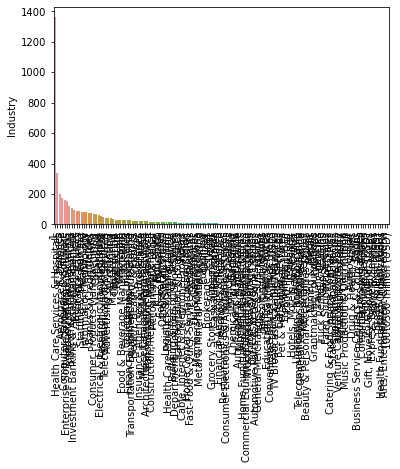

graph for Sector: total = 39


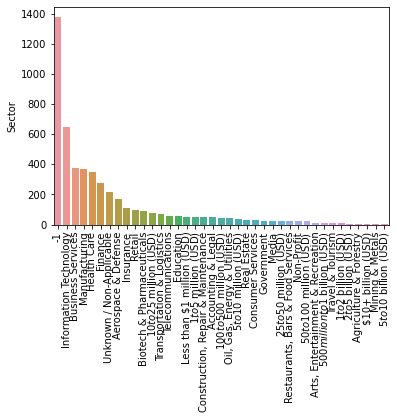

graph for Revenue: total = 13


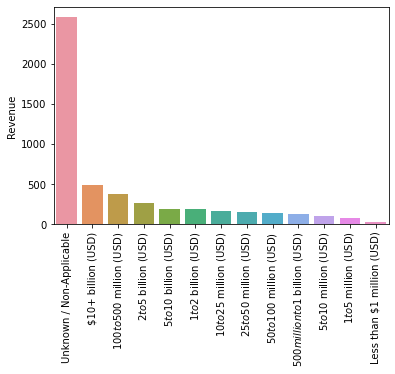

graph for hourly: total = 2


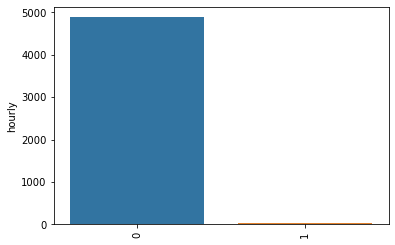

graph for employer_provided: total = 2


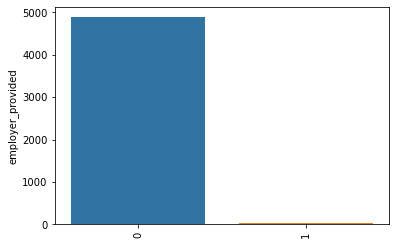

graph for job_state: total = 57


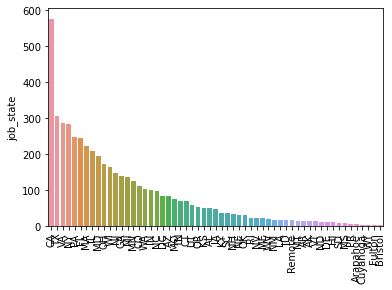

graph for python: total = 2


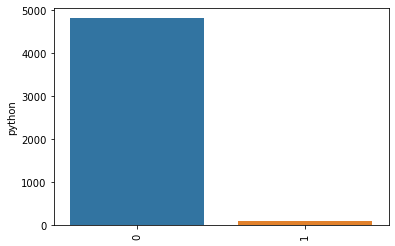

graph for R: total = 2


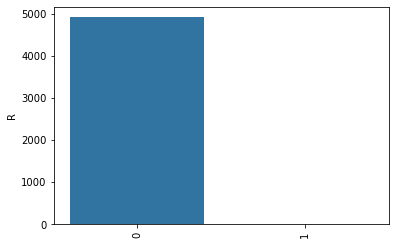

graph for spark: total = 2


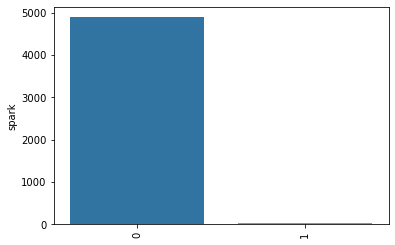

graph for aws: total = 2


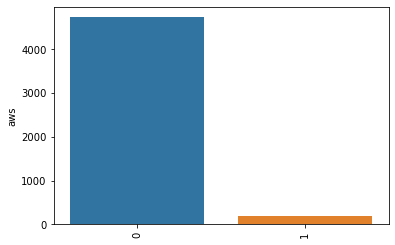

graph for excel: total = 2


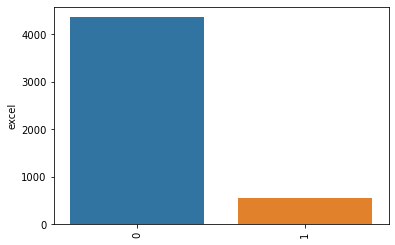

graph for sql: total = 2


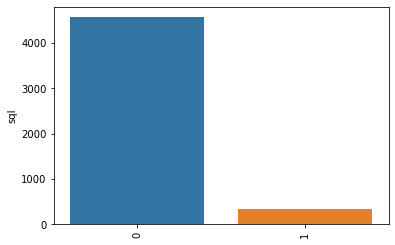

graph for django: total = 2


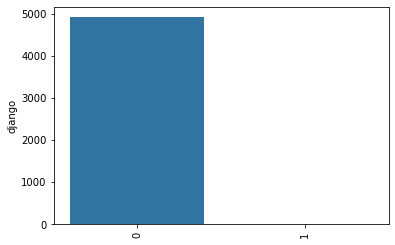

graph for hadoop: total = 2


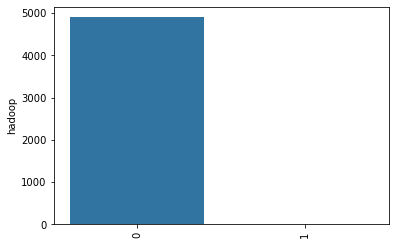

graph for java: total = 2


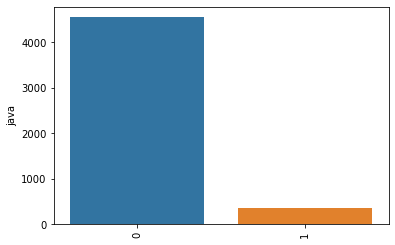

graph for db: total = 2


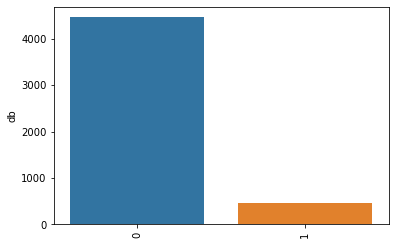

graph for tableau: total = 2


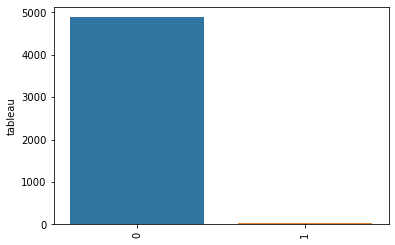

graph for azure: total = 2


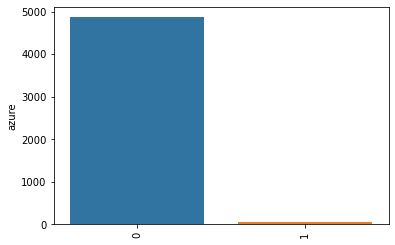

graph for job_title_tag: total = 9


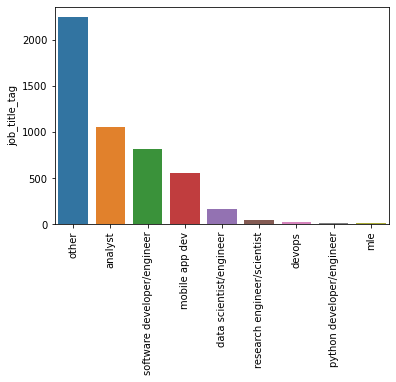

graph for seniority: total = 3


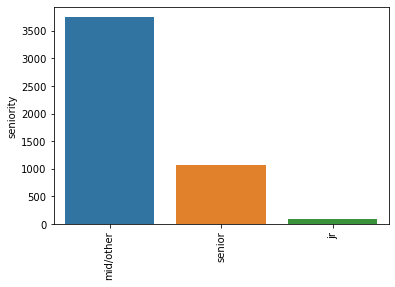

In [33]:
df_cat = df[['Size','Type of ownership','Company Name',
       'Industry', 'Sector', 'Revenue', 'hourly', 'employer_provided', 'job_state',
       'python', 'R', 'spark', 'aws', 'excel', 'sql', 'django', 'hadoop',
       'java', 'db', 'tableau', 'azure', 'job_title_tag', 'seniority',]]


for i in df_cat.columns:
    cat_num = df_cat[i].value_counts()
    print("graph for %s: total = %d" % (i, len(cat_num)))
    chart = sns.barplot(x=cat_num.index, y=cat_num)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
    plt.show()

graph for Location: total = 20


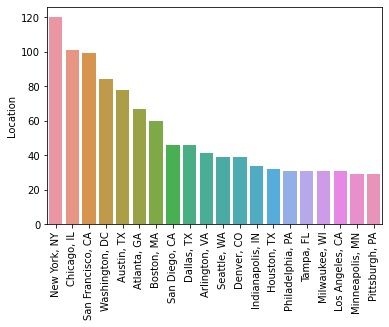

graph for job_state: total = 20


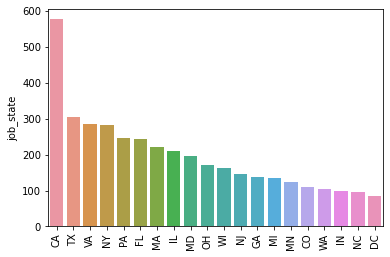

graph for Industry: total = 20


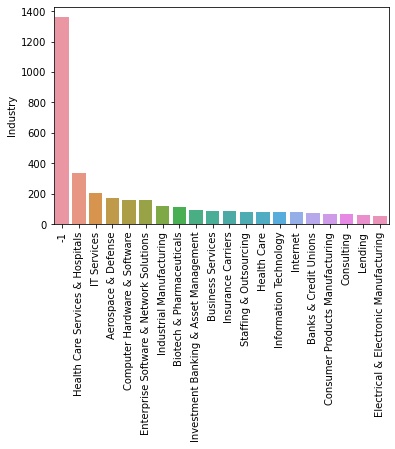

graph for Company Name: total = 20


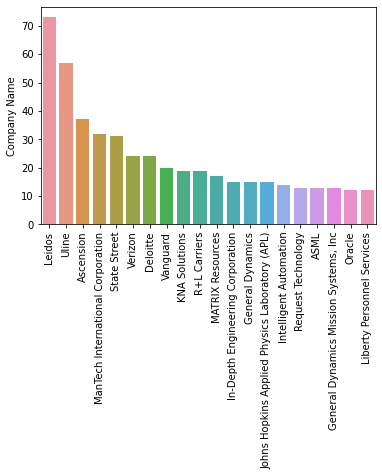

In [34]:
for i in df[['Location', 'job_state', 'Industry','Company Name']].columns:
    cat_num = df[i].value_counts()[:20]
    print("graph for %s: total = %d" % (i, len(cat_num)))
    chart = sns.barplot(x=cat_num.index, y=cat_num)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
    plt.show()

In [35]:
df.columns

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Size', 'Founded', 'Type of ownership',
       'Industry', 'Sector', 'Revenue', 'hourly', 'employer_provided',
       'min_salary', 'max_salary', 'avg_salary', 'job_state', 'age',
       'job_title_tag', 'seniority', 'desc_len', 'python', 'R', 'spark', 'aws',
       'excel', 'sql', 'django', 'hadoop', 'java', 'db', 'tableau', 'azure'],
      dtype='object')

## Pivot tables


In [36]:
pd.options.display.max_rows
pd.set_option('display.max_rows', None)

In [37]:
pd.pivot_table(df, index = 'job_title_tag', values = 'avg_salary')

,avg_salary
job_title_tag,
analyst,73.947947
data scientist/engineer,111.136905
devops,106.413043
mle,114.909091
mobile app dev,108.679091
other,79.769933
python developer/engineer,96.750000
research engineer/scientist,86.820513
software developer/engineer,99.061736


In [38]:
pd.pivot_table(df, index = ['job_title_tag', 'seniority'], values = 'avg_salary')

avg_salary
job_title_tag               seniority            
analyst                     jr          65.105263
                            mid/other   71.605018
                            senior      86.672515
data scientist/engineer     jr          99.500000
                            mid/other  103.858974
                            senior     128.400000
devops                      mid/other   97.000000
                            senior     112.464286
mle                         jr         106.500000
                            mid/other  106.600000
                            senior     124.900000
mobile app dev              jr          88.750000
                            mid/other  106.114967
                            senior     124.361446
other                       jr          69.666667
                            mid/other   73.798281
                            senior     103.671429
python developer/engineer   mid/other   92.800000
                            senior     103.333333
research engineer/scientist mid/other   78.907407
                            senior     104.625000
software developer/engineer jr          82.119048
                            mid/other   92.732177
                            senior     112.158273

In [39]:
pd.pivot_table(df, index = ['Size', 'job_title_tag'], values = 'avg_salary')

avg_salary
Size                    job_title_tag                          
1 to 50 Employees       analyst                       74.436709
                        data scientist/engineer      112.678571
                        devops                        79.000000
                        mle                          109.500000
                        mobile app dev               106.863281
                        other                         84.094527
                        python developer/engineer     95.250000
                        research engineer/scientist   73.428571
                        software developer/engineer   99.490196
10000+ Employees        analyst                       78.843575
                        data scientist/engineer      116.525862
                        devops                       114.250000
                        mle                           78.500000
                        mobile app dev               115.417526
                        other                         87.077586
                        python developer/engineer    105.333333
                        research engineer/scientist   83.333333
                        software developer/engineer  104.878571
1001 to 5000 Employees  analyst                       73.769006
                        data scientist/engineer      118.031250
                        devops                        82.250000
                        mle                          119.500000
                        mobile app dev               109.174419
                        other                         75.902778
                        python developer/engineer     78.000000
                        software developer/engineer   97.843373
201 to 500 Employees    analyst                       73.036585
                        data scientist/engineer      102.029412
                        devops                       115.000000
                        mobile app dev               106.358696
                        other                         73.406404
                        python developer/engineer    105.000000
                        research engineer/scientist   90.333333
                        software developer/engineer   99.840426
5001 to 10000 Employees analyst                       74.440000
                        data scientist/engineer      114.423077
                        devops                       102.750000
                        mle                          106.500000
                        mobile app dev               121.000000
                        other                         78.981308
                        python developer/engineer    109.000000
                        research engineer/scientist  107.833333
                        software developer/engineer  101.418033
501 to 1000 Employees   analyst                       74.825581
                        data scientist/engineer      114.500000
                        devops                        91.500000
                        mle                          152.500000
                        mobile app dev               103.095238
                        other                         81.145695
                        research engineer/scientist  102.250000
                        software developer/engineer  100.657143
51 to 200 Employees     analyst                       74.257143
                        data scientist/engineer      102.700000
                        devops                       112.833333
                        mle                          102.000000
                        mobile app dev               109.383178
                        other                         83.703180
                        python developer/engineer     92.666667
                        research engineer/scientist  100.055556
                        software developer/engineer   94.720588
Unknown                 analyst                       67.470588
                     

In [40]:
pd.pivot_table(df, index = ['Revenue', 'job_title_tag'], values = 'avg_salary')

avg_salary
Revenue                          job_title_tag                          
$1 to $2 billion (USD)           analyst                       73.908163
                                 data scientist/engineer      108.285714
                                 devops                        84.500000
                                 mle                          106.500000
                                 mobile app dev               109.031250
                                 other                         83.552326
                                 python developer/engineer     93.500000
                                 research engineer/scientist  115.500000
                                 software developer/engineer  108.516667
$1 to $5 million (USD)           analyst                       75.687500
                                 mobile app dev               112.590909
                                 other                         73.606061
                                 python developer/engineer     93.000000
                                 software developer/engineer  100.900000
$10 to $25 million (USD)         analyst                       80.630952
                                 data scientist/engineer      103.250000
                                 devops                       112.500000
                                 mobile app dev                97.500000
                                 other                         79.479452
                                 python developer/engineer     94.500000
                                 software developer/engineer   93.500000
$10+ billion (USD)               analyst                       84.135294
                                 data scientist/engineer      116.739130
                                 devops                       116.857143
                                 mle                          131.833333
                                 mobile app dev               121.166667
                                 other                         94.892344
                                 python developer/engineer    105.500000
                                 software developer/engineer  108.675325
$100 to $500 million (USD)       analyst                       73.296296
                                 data scientist/engineer      102.357143
                                 devops                        91.500000
                                 mobile app dev               104.606061
                                 other                         78.613095
                                 software developer/engineer   98.366667
$2 to $5 billion (USD)           analyst                       72.166667
                                 data scientist/engineer      113.444444
                                 mle                          100.500000
                                 mobile app dev               110.452381
                                 other                         75.427966
                                 python developer/engineer     92.500000
                                 software developer/engineer  100.475000
$25 to $50 million (USD)         analyst                       73.961538
                                 data scientist/engineer      104.250000
                                 devops                       119.500000
                                 mle                          102.000000
                                 mobile app dev               108.892857
                                 other                         84.836538
                                 research engineer/scientist  106.357143
                                 software developer/engineer   96.051724
$5 to $10 billion (USD)          analyst                       75.605634
                                 data scientist/engineer      115.650000
                                 devops                        96.000000
                                 mle           

In [41]:
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')

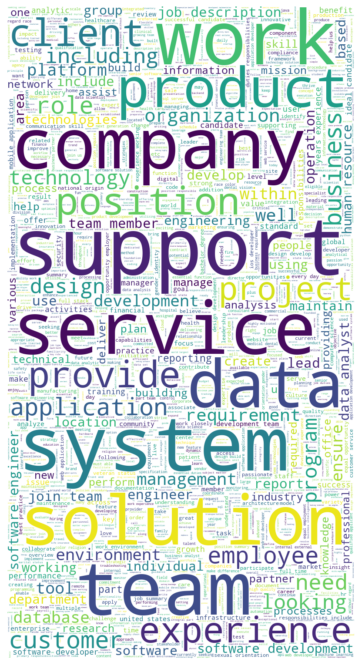

In [42]:
words = " ".join(df['Job Description'])

def punctuation_stop(text):
    """remove punctuation and stop words"""
    filtered = []
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    for w in word_tokens:
        if w not in stop_words and w.isalpha():
            filtered.append(w.lower())
    return filtered


words_filtered = punctuation_stop(words)


text = " ".join([ele for ele in words_filtered])

wc= WordCloud(background_color="white", random_state=1,stopwords=STOPWORDS, max_words = 2000, width =800, height = 1500)
wc.generate(text)

plt.figure(figsize=[12,12])
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

In [43]:
df.columns

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Size', 'Founded', 'Type of ownership',
       'Industry', 'Sector', 'Revenue', 'hourly', 'employer_provided',
       'min_salary', 'max_salary', 'avg_salary', 'job_state', 'age',
       'job_title_tag', 'seniority', 'desc_len', 'python', 'R', 'spark', 'aws',
       'excel', 'sql', 'django', 'hadoop', 'java', 'db', 'tableau', 'azure'],
      dtype='object')

In [44]:
df.to_csv('../Data/preprocessed_data.csv')